In [1]:
import urllib, json, copy
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
bg = '#11134A'
txt = '#FAF9F1'
giallo = '#FEE08B'
giallo_tras = '#FEE08B20'
palette = [ '#E48484', '#F7956E', '#FDB761', '#FEE08B', '#E6F598', '#ABDDA4', '#66C2A5', '#6FCED9', '#7F8DDD', '#A084C3' ]

mpl.rcParams['text.color'] = txt
mpl.rcParams['axes.labelcolor'] = txt
mpl.rcParams['xtick.color'] = txt
mpl.rcParams['ytick.color'] = txt
mpl.rcParams['axes.facecolor'] = bg
mpl.rcParams['axes.edgecolor'] = txt

In [3]:
areas_url = 'https://opendata.comune.ra.it/dataset/5ec2b0b3-24f7-4b75-987d-f53658d80064/resource/a8402fb2-3fd5-4a53-a691-263bb8e82640/download/sitra01aa01areeterritoriali.geojson'
areas_response = urllib.request.urlopen(areas_url)
areas_data = json.loads(areas_response.read())
#print(areas_data)
areas = gpd.GeoDataFrame.from_features(areas_data)
areas = areas[['geometry', 'NOME_AT']]
areas = areas.rename( columns = { 'NOME_AT' : 'frazione' } )
areas = areas.set_crs('epsg:4326')
areas = areas.to_crs( epsg = 32633 ) #utm

In [4]:
area_tot = copy.copy(areas)
area_tot['dis'] = 1
area_tot = area_tot.dissolve(by='dis').reset_index(drop = True)

In [5]:
points_url = 'https://opendata.comune.ra.it/dataset/bde8e128-d925-4e53-b7c1-8464cc383eea/resource/544be0f6-d60c-4d14-93c2-a5c7db3d9baa/download/servizio_istruzione.json'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
points = points[['CLASSE', 'TIPO', 'geometry']]
points = points.rename( columns = {'CLASSE' : 'classe', 'TIPO' : 'tipo'} )
# print(points.crs)
points = points.set_crs('epsg:3004')
points = points.to_crs( epsg = 32633 ) #utm
print(points.head(3))
# points.plot()

       classe             tipo                        geometry
0  Scolastico  Scuole Primaria  POINT (280595.706 4904318.283)
1  Scolastico  Scuole Primaria  POINT (281252.215 4920617.263)
2  Scolastico  Scuole Primaria  POINT (274122.332 4935857.147)


In [6]:
schools = areas.overlay( points, how = 'intersection', keep_geom_type = False )
print(schools.head(3))

   frazione       classe                              tipo  \
0  DEL MARE     Infanzia                   Nidi d'infanzia   
1  DEL MARE   Scolastico  Scuole Secondarie di Primo Grado   
2  DEL MARE  Universita'                       Universita'   

                         geometry  
0  POINT (283111.663 4929301.273)  
1  POINT (285450.797 4920808.373)  
2  POINT (283148.398 4928875.024)  


In [7]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red' : ((0.0, inter_from_256(17), inter_from_256(17)),
            (1.0, inter_from_256(255), inter_from_256(255))),
    'green' : ((0.0, inter_from_256(19), inter_from_256(19)),
            (1.0, inter_from_256(189), inter_from_256(189))),
    'blue' : ((0.0, inter_from_256(74), inter_from_256(74)),
            (1.0, inter_from_256(0), inter_from_256(0)))
}
y_grd = matplotlib.colors.LinearSegmentedColormap('y_grd', segmentdata=cdict)

In [8]:
def plot_coverage(school_type):
    df = schools[['frazione', 'tipo']]
    df = df[df['tipo'].str.contains(school_type)]
    df = df.rename( columns = { 'tipo' : 'num' } )
    df = df.groupby('frazione').count().reset_index()
    df = df.merge( areas, on = 'frazione' )
    df = gpd.GeoDataFrame(df)
    fig, ax = plt.subplots( figsize = (10, 10) )
    areas.plot( ax = ax, color = 'none', edgecolor = txt, figsize = (20, 15) )
    df.plot( ax = ax,  column = 'num', cmap = y_grd, legend = True )
    plt.title(school_type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor(bg)

In [9]:
def plot_buff(school_type):
    df = points[['tipo', 'geometry']]
    df = df[df['tipo'].str.contains(school_type)]
    small_buff = df[:]
    small_buff['geometry'] = small_buff.geometry.buffer(500)
    small_buff['dissovefield'] = 1
    small_buff = small_buff.dissolve( by = 'dissovefield' )
    small_buff = small_buff.overlay(area_tot, how='intersection')
    big_buff = df[:]
    big_buff['geometry'] = big_buff.geometry.buffer(1250)
    big_buff = big_buff.overlay(area_tot, how='intersection')
    df['geometry'] = df.geometry.buffer(15) # with touple coordinates plots a big dot, turning it in a polygon prevents that
    fig, ax = plt.subplots( figsize = (10, 10) )
    big_buff.plot(ax = ax, color = giallo_tras)
    small_buff.plot(ax = ax, color = 'none', linewidth = 1, edgecolor = giallo)
    df.plot(ax = ax, color = txt)
    areas.plot(ax = ax, color = 'none', edgecolor = txt)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor(bg)

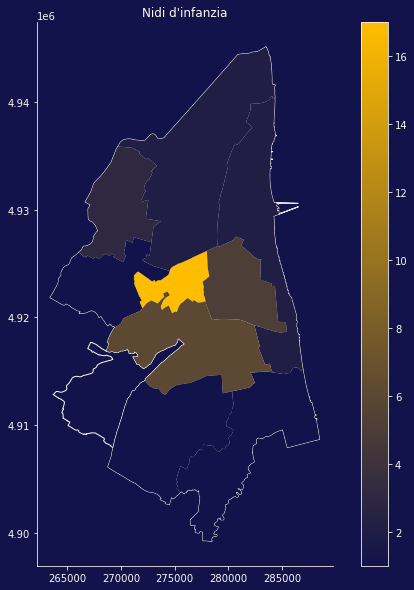

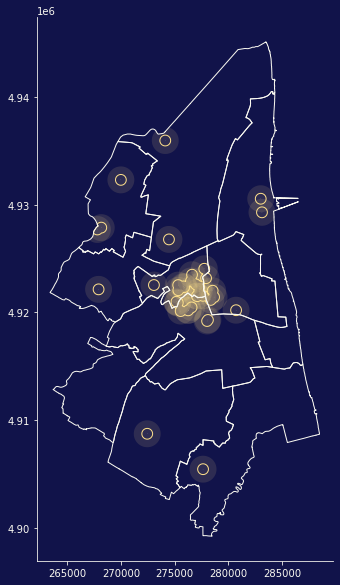

In [10]:
plot_coverage('Nidi d\'infanzia')
plot_buff('Nidi d\'infanzia')

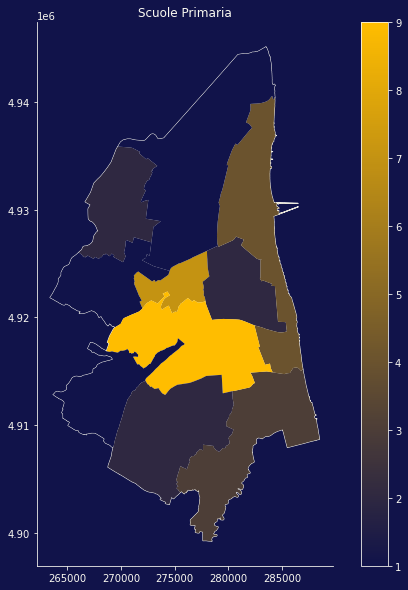

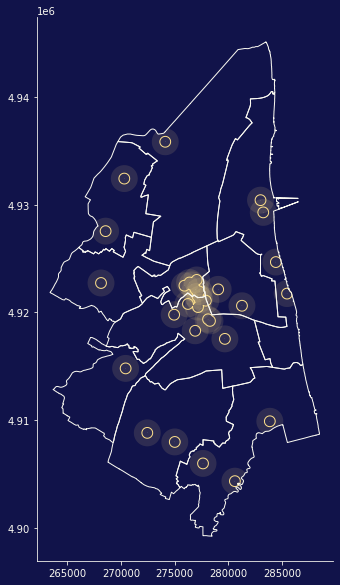

In [11]:
plot_coverage('Scuole Primaria')
plot_buff('Scuole Primaria')

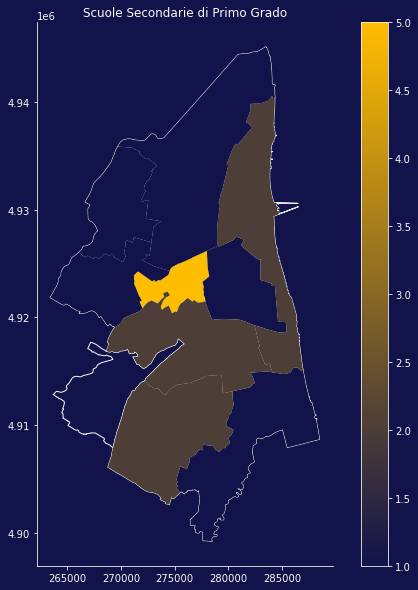

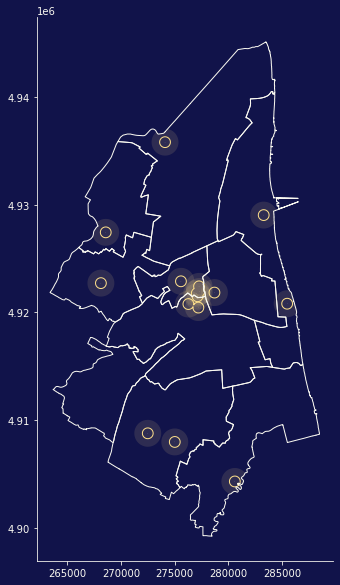

In [12]:
plot_coverage('Scuole Secondarie di Primo Grado')
plot_buff('Scuole Secondarie di Primo Grado')

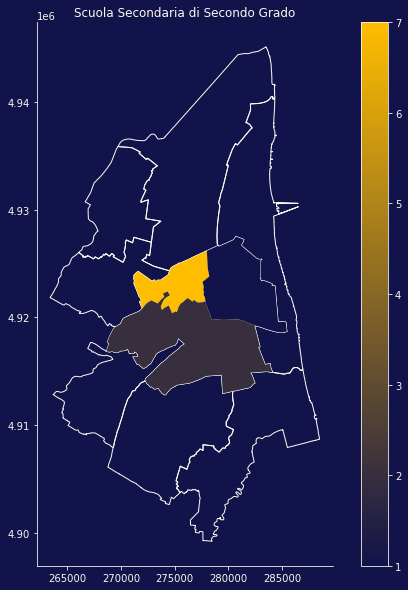

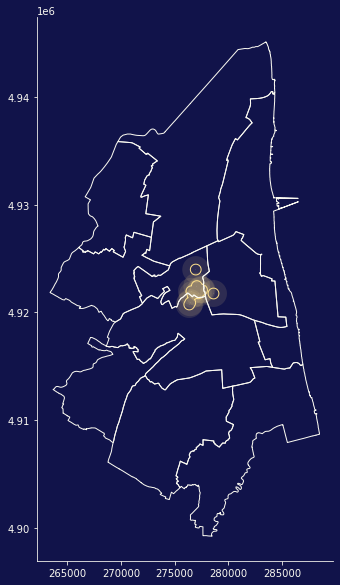

In [13]:
plot_coverage('Scuola Secondaria di Secondo Grado')
plot_buff('Scuola Secondaria di Secondo Grado')